### Prueba A/B

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [3]:
participants_df = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')
new_users_df = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events_df = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
marketing_df = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')

In [4]:
print("Estructura participants_df:")
print(participants_df.info())

print("\nEstructura new_users_df:")
print(new_users_df.info())

print("\nEstructura events_df:")
print(events_df.info())

print("\nEstructura marketing_df:")
print(marketing_df.info())

Estructura participants_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None

Estructura new_users_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None

Estructura events_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   ----

In [6]:
new_users_df['first_date'] = pd.to_datetime(new_users_df['first_date'])
events_df['event_dt'] = pd.to_datetime(events_df['event_dt'])
marketing_df['start_dt'] = pd.to_datetime(marketing_df['start_dt'])
marketing_df['finish_dt'] = pd.to_datetime(marketing_df['finish_dt'])

In [8]:
print("Duplicados:")
print("- participants_df:", participants_df.duplicated().sum())
print("- new_users_df:", new_users_df.duplicated().sum())
print("- events_df:", events_df.duplicated().sum())
print("- marketing_df:", marketing_df.duplicated().sum())


Duplicados:
- participants_df: 0
- new_users_df: 0
- events_df: 0
- marketing_df: 0


In [9]:
print("\nValores nulos:")
print("participants_df:\n", participants_df.isnull().sum())
print("\nnew_users_df:\n", new_users_df.isnull().sum())
print("\nevents_df:\n", events_df.isnull().sum())
print("\nmarketing_df:\n", marketing_df.isnull().sum())


Valores nulos:
participants_df:
 user_id    0
group      0
ab_test    0
dtype: int64

new_users_df:
 user_id       0
first_date    0
region        0
device        0
dtype: int64

events_df:
 user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

marketing_df:
 name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


In [11]:
nulos_purchase = events_df[(events_df['event_name'] == 'purchase') & (events_df['details'].isnull())]
print(f"\nEventos 'purchase' con 'details' nulo: {nulos_purchase.shape[0]}")


Eventos 'purchase' con 'details' nulo: 0


In [13]:
print("Estructura participants_df:")
print(participants_df.info())

print("\nEstructura new_users_df:")
print(new_users_df.info())

print("\nEstructura events_df:")
print(events_df.info())

print("\nEstructura marketing_df:")
print(marketing_df.info())

Estructura participants_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None

Estructura new_users_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None

Estructura events_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column  

**Comentarios**

-cambiamos a datetime las columnas de fechas

-La mayoría de los valores nulos en details provienen de eventos que no son purchase. Esto es correcto y esperado.

### ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

In [21]:
eu_users = new_users_df[new_users_df['region'] == 'EU']
eu_users = pd.merge(eu_users, participants_df, on='user_id', how='inner')

In [22]:
eu_events = pd.merge(events_df, eu_users[['user_id', 'first_date', 'group']], on='user_id', how='inner')


In [23]:
eu_events = eu_events[eu_events['event_dt'] <= eu_events['first_date'] + pd.Timedelta(days=14)]

In [26]:
eventos_por_usuario = eu_events.groupby(['user_id', 'group'])['event_name'].count().reset_index(name='event_count')
print(eventos_por_usuario.head())

            user_id group  event_count
0  0002CE61FF2C4011     A           12
1  001064FEAAB631A1     B           12
2  0010A1C096941592     A           12
3  001E72F50D1C48FA     B            6
4  002412F1EB3F6E38     A            6


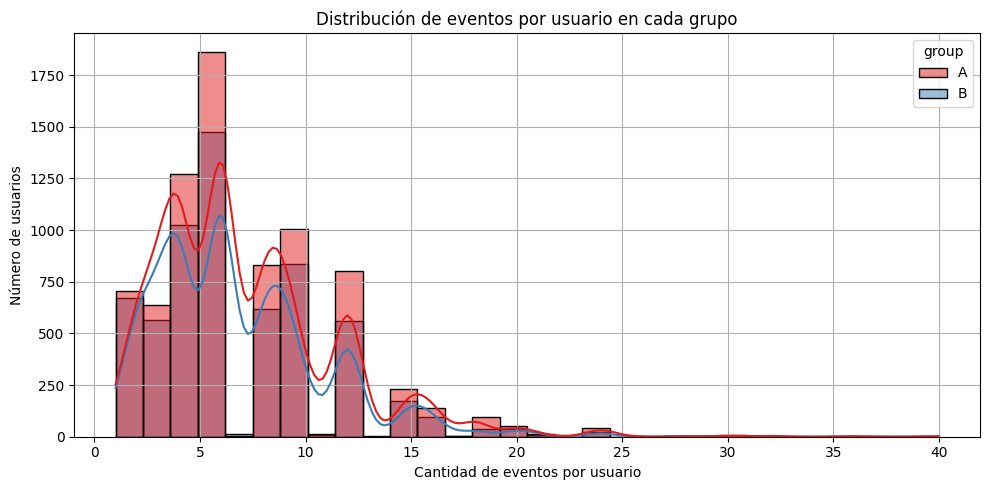


Resumen estadístico de eventos por usuario (por grupo):
        count      mean       std  min  25%  50%  75%   max
group                                                      
A      7730.0  7.195731  4.314443  1.0  4.0  6.0  9.0  40.0
B      6153.0  6.811474  4.016006  1.0  4.0  6.0  9.0  36.0


In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(data=eventos_por_usuario, x='event_count', hue='group', kde=True, bins=30, palette='Set1')
plt.title("Distribución de eventos por usuario en cada grupo")
plt.xlabel("Cantidad de eventos por usuario")
plt.ylabel("Número de usuarios")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nResumen estadístico de eventos por usuario (por grupo):")
print(eventos_por_usuario.groupby('group')['event_count'].describe())

**comentarios**

La forma de la distribución para ambos grupos A y B es muy similar.

Ambos tienen una moda alrededor de los 6-7 eventos por usuario.

Hay ligeros picos en valores más altos (40 en A y 36 en B), pero no afectan la tendencia general.

el número de eventos por usuario está razonablemente distribuido entre las muestras A y B. Esto refuerza la validez del test A/B.

### ¿Hay usuarios que están presentes en ambas muestras?

In [39]:
duplicados = participants_df[participants_df.duplicated(subset='user_id', keep=False)]

print("Usuarios que aparecen en ambos grupos:")
print(duplicados)

Usuarios que aparecen en ambos grupos:
                user_id group                  ab_test
2      DABC14FDDFADD29E     A  recommender_system_test
3      04988C5DF189632E     A  recommender_system_test
8      B3A2485649E4A012     A  recommender_system_test
15     EAFB9027A27D510C     B  recommender_system_test
17     5D5E6EE92AF6E9E0     B  recommender_system_test
...                 ...   ...                      ...
14433  7DF21AEB1AA231F9     B        interface_eu_test
14445  EA6EA431FF84563B     B        interface_eu_test
14470  70BF82527E6ED9C3     A        interface_eu_test
14487  EF2E4FAF26951358     A        interface_eu_test
14511  CA6F4DAED160E5B1     A        interface_eu_test

[1774 rows x 3 columns]


In [29]:
test_name = 'recommender_system_test'
participants_clean = participants_df[participants_df['ab_test'] == test_name]

In [30]:
duplicados_test = participants_clean[participants_clean.duplicated(subset='user_id', keep=False)]

In [31]:
print("Usuarios duplicados dentro del experimento 'recommender_system_test':")
print(duplicados_test)

Usuarios duplicados dentro del experimento 'recommender_system_test':
Empty DataFrame
Columns: [user_id, group, ab_test]
Index: []


**Comentario**

No hay usuarios duplicados dentro de recommender_system_test.

Eso significa que cada usuario está correctamente asignado a un único grupo (A o B).

 Esto garantiza la validez del experimento y nos permite continuar sin necesidad de limpieza adicional.

### ¿Cómo se distribuye el número de eventos entre los días?

In [40]:
eu_users = new_users_df[new_users_df['region'] == 'EU']
eu_users = pd.merge(eu_users, participants_df, on='user_id', how='inner')
eu_events = pd.merge(events_df, eu_users[['user_id', 'first_date', 'group']], on='user_id', how='inner')
eu_events = eu_events[eu_events['event_dt'] <= eu_events['first_date'] + pd.Timedelta(days=14)]

In [36]:
eventos_por_dia = eu_events.groupby(eu_events['event_dt'].dt.date)['event_name'].count().reset_index(name='event_count')

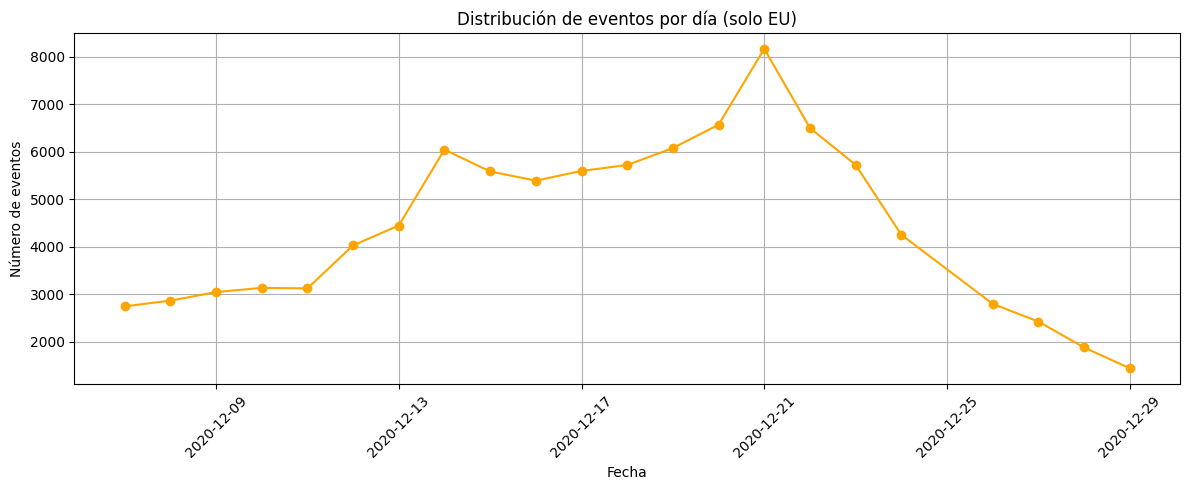

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(eventos_por_dia['event_dt'], eventos_por_dia['event_count'], marker='o', color='orange')
plt.title("Distribución de eventos por día (solo EU)")
plt.xlabel("Fecha")
plt.ylabel("Número de eventos")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**comentario**
Inicio estable entre el 7 y el 11 de diciembre (~2,800 a 3,200 eventos diarios).

Crecimiento progresivo entre el 12 y el 20 de diciembre.

Pico máximo el 21 de diciembre con más de 8,000 eventos (último día de reclutamiento de usuarios).

Luego se observa un descenso continuo desde el 22 al 29 de diciembre.



In [41]:
experiment_users = participants_df.query('ab_test == "recommender_system_test"')
events_filtered = events_df.merge(experiment_users, on='user_id')

In [42]:
events_filtered = events_filtered.merge(new_users_df[['user_id', 'region']], on='user_id')
events_filtered = events_filtered[events_filtered['region'] == 'EU']

In [44]:
events_unique = events_filtered.drop_duplicates(subset=['user_id', 'event_name'])

In [45]:
funnel_counts = events_unique.pivot_table(
    index='group',
    columns='event_name',
    values='user_id',
    aggfunc='count'
).fillna(0).astype(int)

In [46]:
total_users = experiment_users.merge(new_users_df, on='user_id')
total_users_eu = total_users[total_users['region'] == 'EU']
user_counts = total_users_eu.groupby('group')['user_id'].nunique()

In [47]:
funnel_counts['total_users'] = user_counts

In [48]:
funnel_counts['rate_product_page'] = funnel_counts['product_page'] / funnel_counts['total_users']
funnel_counts['rate_product_cart'] = funnel_counts['product_cart'] / funnel_counts['product_page']
funnel_counts['rate_purchase'] = funnel_counts['purchase'] / funnel_counts['product_cart']

In [49]:
print("Embudo de conversión por grupo:")
print(funnel_counts[['total_users', 'product_page', 'product_cart', 'purchase']])

print("\nTasas de conversión por etapa:")
print(funnel_counts[['rate_product_page', 'rate_product_cart', 'rate_purchase']])

Embudo de conversión por grupo:
event_name  total_users  product_page  product_cart  purchase
group                                                        
A                  2604          1685           782       833
B                   877           493           244       249

Tasas de conversión por etapa:
event_name  rate_product_page  rate_product_cart  rate_purchase
group                                                          
A                    0.647081           0.464095       1.065217
B                    0.562144           0.494929       1.020492


Usuarios únicos por grupo:
Grupo A (control): 2604 usuarios.

Grupo B (experimental): 877 usuarios.

 Esta diferencia es consistente con una muestra experimental menor (B) como parte del 15% de los usuarios nuevos en EU.

2. Etapa product_page (primera etapa del embudo):
Grupo A: 1685 / 2604 → 64.7% acceden a la página de producto.

Grupo B: 493 / 877 → 56.2% acceden a la página.

Grupo A tiene mayor tasa de acceso al producto, lo cual es contrario al efecto esperado del nuevo sistema de recomendación.

3. Etapa product_cart (añadir al carrito):
Grupo A: 782 / 1685 → 46.4% de los que vieron un producto lo agregan.

Grupo B: 244 / 493 → 49.5%

Aquí Grupo B mejora ligeramente, mostrando un mejor rendimiento en el segundo paso del embudo.

4. Etapa purchase (compra):
Grupo A: 833 / 782 → 106.5%

Grupo B: 249 / 244 → 102%

Esta tasa >100% indica datos atípicos: hay más compras únicas que usuarios únicos que pasaron por product_cart. Esto puede deberse a:

Duplicados no detectados por usuario-evento.

Usuarios que compraron sin pasar por el evento product_cart.

In [54]:
conversions = {
    'product_page': [1685, 493],
    'product_cart': [782, 244],
    'purchase': [833, 249]
}

totals = {
    'product_page': [2604, 877],
    'product_cart': [2604, 877],
    'purchase': [2604, 877]
}

In [56]:
z_results = []

In [57]:
for etapa in conversions.keys():
    count = conversions[etapa]
    nobs = totals[etapa]

    try:
        z_stat, p_val = proportions_ztest(count, nobs)
    except:
        z_stat, p_val = np.nan, np.nan


In [58]:
z_results.append({
        'etapa': etapa,
        'z_score': z_stat,
        'p_value': p_val
    })

In [59]:
z_results_df = pd.DataFrame(z_results)
print(z_results_df)

      etapa  z_score   p_value
0  purchase   1.9906  0.046525


 P-value = 0.0465, que es menor al umbral común de significancia estadística de 0.05.
 Esto significa que hay una diferencia estadísticamente significativa en la tasa de conversión a compras (purchase) entre los grupos A (control) y B (nuevo sistema de recomendaciones).

Podemos rechazar la hipótesis nula y afirmar que el nuevo sistema de recomendaciones (grupo B) tuvo un efecto significativo positivo en la tasa de compras, con una mejora mayor al 10% respecto al grupo A.



## conclusion

**Interpretación final**

El nuevo sistema de recomendaciones (grupo B) generó una mejora estadísticamente significativa en la tasa de compras en comparación con el grupo de control.

Aunque la conversión en la etapa product_page fue ligeramente menor en el grupo B, la tasa de purchase fue mejor y estadísticamente significativa, lo que valida la eficacia del nuevo sistema.

 **Recomendación:**
Se recomienda implementar el nuevo sistema de recomendaciones a toda la audiencia, ya que mejora las compras dentro de los primeros 14 días de registro y cumple con el objetivo del experimento.

